# Bike Sharing Demand Prediction

### Importing libraries

In [1]:
# importing necessary libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
#Read the data
df = pd.read_csv('day.csv')

In [3]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#shape of data
df.shape

(730, 16)

In [5]:
# to check if data has any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### Data Cleaning

In [6]:
#Renaming columns in df
df=df.rename(columns={'dteday': 'date','yr':'year','mnth':'month','hum':'humidity','cnt':'count'})

In [7]:
# conversion dteday from object type to date format
df['date'] = df['date'].astype('datetime64') 
df.head()

,instant,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [8]:
#checking for null values
df.isnull().sum()

instant       0
date          0
season        0
year          0
month         0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

From the above data information we understand that there are 16 columns with all numeric values with no missing or null values

In [9]:
# To Check important metrics like min, max, mean of data
df.describe()

,instant,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Mapping the column content as per attributes
Season

Month

Weekday

Weathersit

In [10]:
# Mapping of Season 
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

# Mapping of Month 
df['month'] = df['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
                        9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

# Mapping of weekday
df['weekday'] = df['weekday'].map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'})

# Mapping of weathersit 
df['weathersit'] = df['weathersit'].map({1:'Clear', 2:'Mist + Cloudy', 3:'Light Snow', 4:'Snow + Fog'})

df.head()

,instant,date,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,1,2018-01-01,spring,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,spring,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Vizualization of Numerical data

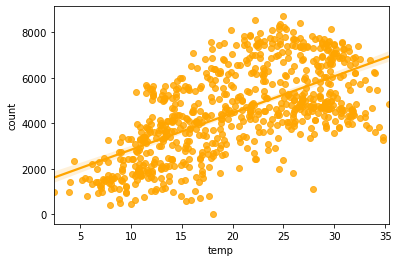

In [11]:
# Check how temperature variable influencing count variable
sns.regplot(x='temp',y='count',data=df, color='orange')
plt.show()

Bike Rentals is increasing gradually as there is rise in temperature.

Count of bike hire is more when temperature is 25 degree celcius.

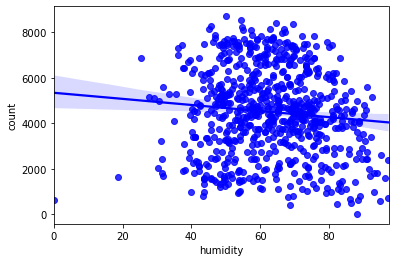

In [12]:
# Check the relation between humidity & Count
sns.regplot(x='humidity', y='count',data=df, color='blue')
plt.show()

Bike rental is more when humidity is more.

Seems to be dense between 40 and 80 units.

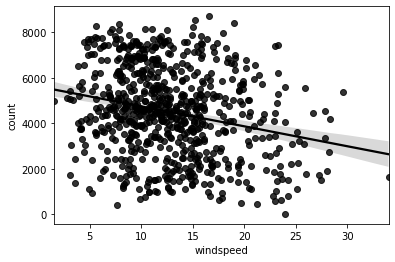

In [13]:
# Check the relation between windspeed & count
sns.regplot(x='windspeed',y='count',data=df, color='black')
plt.show()

Bike rental is more when windspeed is moderate.

Seems to be dense between 10 and 20 units.

### pairplot for numerical variables

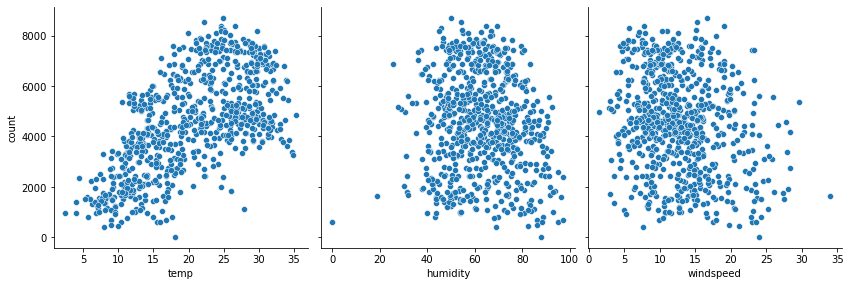

In [15]:
# checking the distribution of the numerical variables across the target variable.
sns.pairplot(df, x_vars=['temp', 'humidity', 'windspeed'], y_vars='count',size=4, aspect=1, kind='scatter')
plt.show()

### Vizualization of categorical data

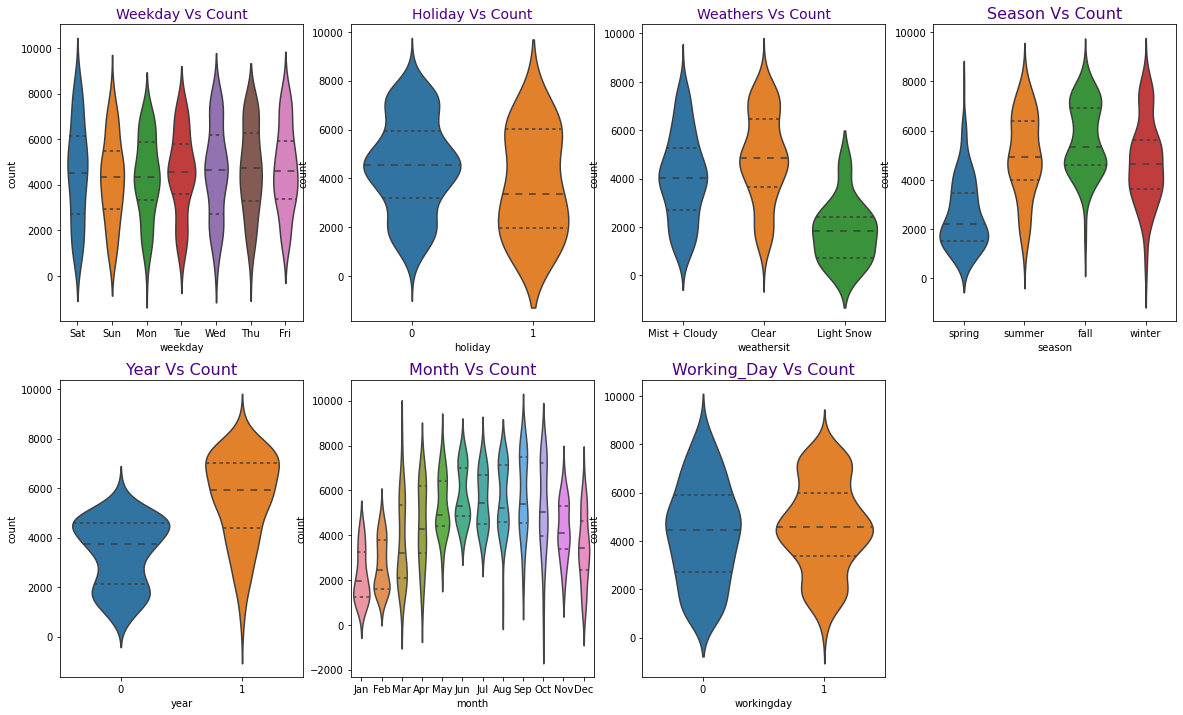

In [179]:
plt.figure(figsize=(20, 12))

plt.subplot(2,4,1)
sns.violinplot(x = 'weekday', y = 'count', data = df, inner="quartile")
plt.title("Weekday Vs Count", fontsize=14, color= "indigo")

plt.subplot(2,4,2)
sns.violinplot(x = 'holiday', y = 'count', data = df, inner="quartile")
plt.title("Holiday Vs Count", fontsize=14, color= "indigo")

plt.subplot(2,4,3)
sns.violinplot(x = 'weathersit', y = 'count', data = df, inner="quartile")
plt.title("Weathers Vs Count", fontsize=14, color= "indigo")

plt.subplot(2,4,4)
sns.violinplot(x = 'season', y = 'count', data = df, inner="quartile")
plt.title("Season Vs Count", fontsize=16, color= "indigo")

plt.subplot(2,4,5)
sns.violinplot(x = 'year', y = 'count', data = df, inner="quartile")
plt.title("Year Vs Count", fontsize=16, color= "indigo")

plt.subplot(2,4,6)
sns.violinplot(x = 'month', y = 'count', data = df, inner="quartile")
plt.title("Month Vs Count", fontsize=16, color= "indigo")

plt.subplot(2,4,7)
sns.violinplot(x = 'workingday', y = 'count', data = df, inner="quartile")
plt.title("Working_Day Vs Count", fontsize=16, color= "indigo")

plt.show()

#### Observations

Bike Rental booking count is evenly spread on all days of week.

Bike booking count is more when weather is clear, than on rainy or misty weather days.

The count of bike booking is more in year 2019 when compared to 2018.

In the summer and fall season bike booking is more when compared to spring and winter.

### Heat Map
To get idea on values of correlation can check on heat map

<AxesSubplot:>

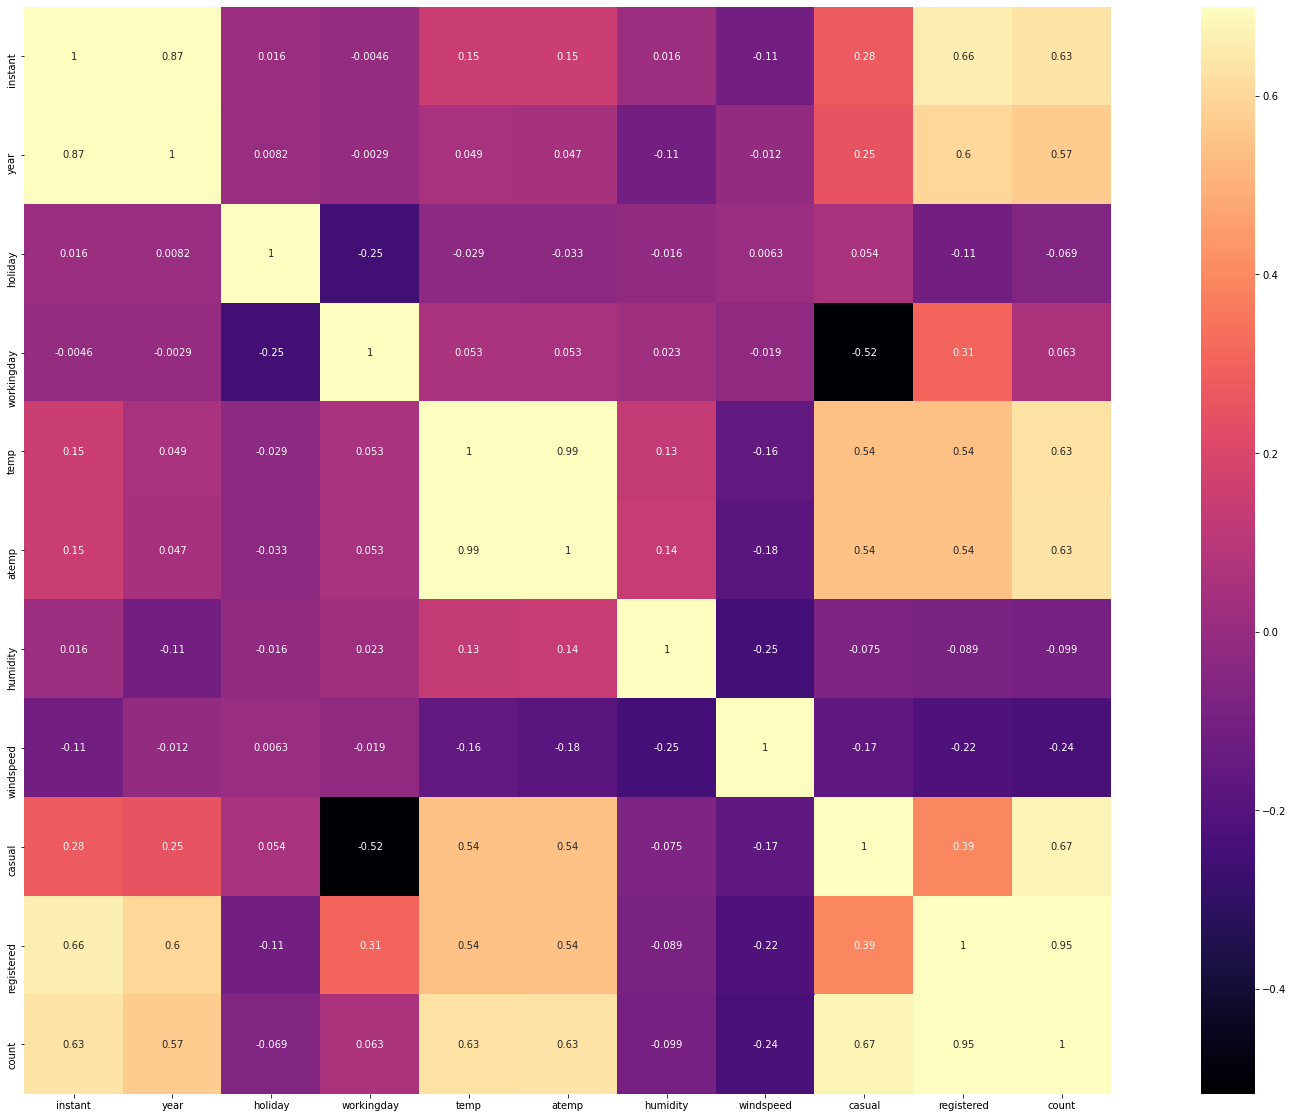

In [180]:
plt.figure(figsize=(32,20))
matrix=df.corr()
sns.heatmap(matrix,vmax=0.7,square=True,cmap='magma',annot=True)

1. Instant variable is not that influencing on count of bike rental thus this collumn can be dropped.

2. Number of Casual and Registered users aggregate to count, these two collumn can be dropped.

3. dteday variable does not have that much influence over count varible.

4. However there are other varibles like weekday, month, year which constitues to same data so dteday can be dropped.

### Data Preprocessing
Steps under Data Preprocessing

Data Encoding

Splitting into training and test set

Rescaling of variables


#### Dropping of unwanted collumns

In [181]:
df.drop(['instant','date','casual','registered'],axis=1,inplace=True)

In [182]:
df.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,count
0,spring,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


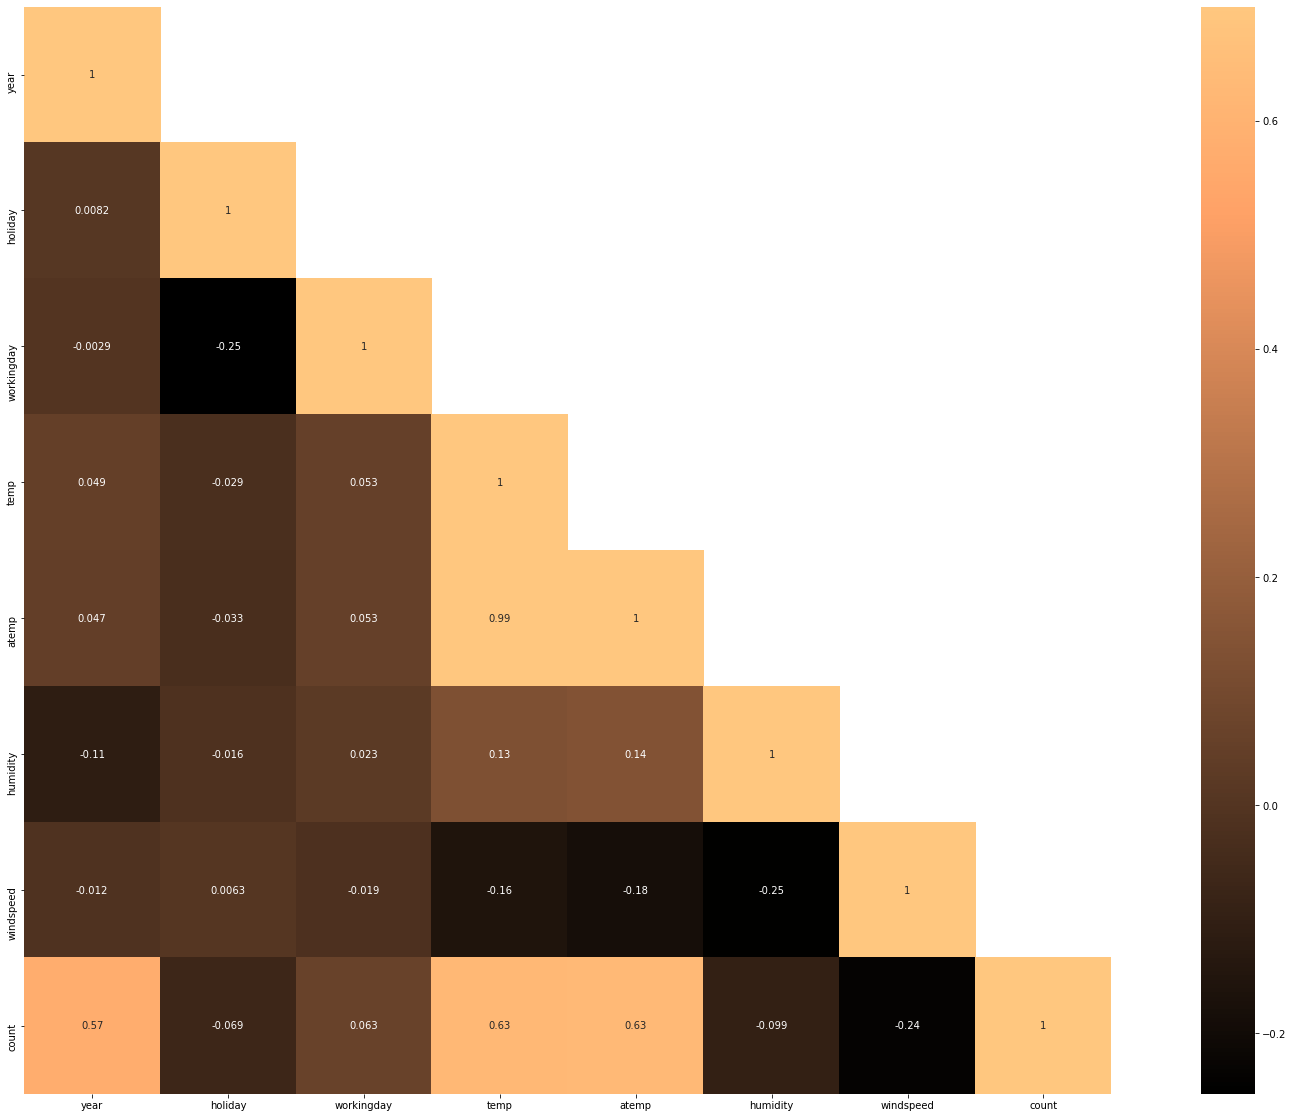

In [183]:
#Recheck the Collinearity of remaining variables
plt.figure(figsize=(32,20))

mask = np.array(df.corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(df.corr(), mask=mask, vmax=.7, square=True, annot=True, cmap = "copper");

 temp and atemp are highly correlated with each other, so let's drop atemp(since they are redundant).

In [184]:
df.drop(['atemp'],axis=1,inplace=True)

### Data Encoding

Converting the non numeric categorical variables to dummy variables

In [185]:
# Conversion of categorical variables to dummy variables

# Creation of month dummy variable
month = pd.get_dummies(df['month'], drop_first=True)

# Creation of weekday dummy variable
weekday = pd.get_dummies(df['weekday'], drop_first=True)

# Creation of weathersit dummy variable
weathersit = pd.get_dummies(df['weathersit'], drop_first=True)

# Creation of season dummy variable
season = pd.get_dummies(df['season'], drop_first=True)

In [186]:
# Concatenation of all dummy varible to bikehire dataset
df=pd.concat([month,weekday,weathersit,season,df],axis=1)

df.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,...,year,month,holiday,weekday,workingday,weathersit,temp,humidity,windspeed,count
0,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Sat,0,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Sun,0,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Mon,1,Clear,8.050924,43.7273,16.636703,1349
3,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Tue,1,Clear,8.200000,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,0,0,0,...,0,Jan,0,Wed,1,Clear,9.305237,43.6957,12.522300,1600


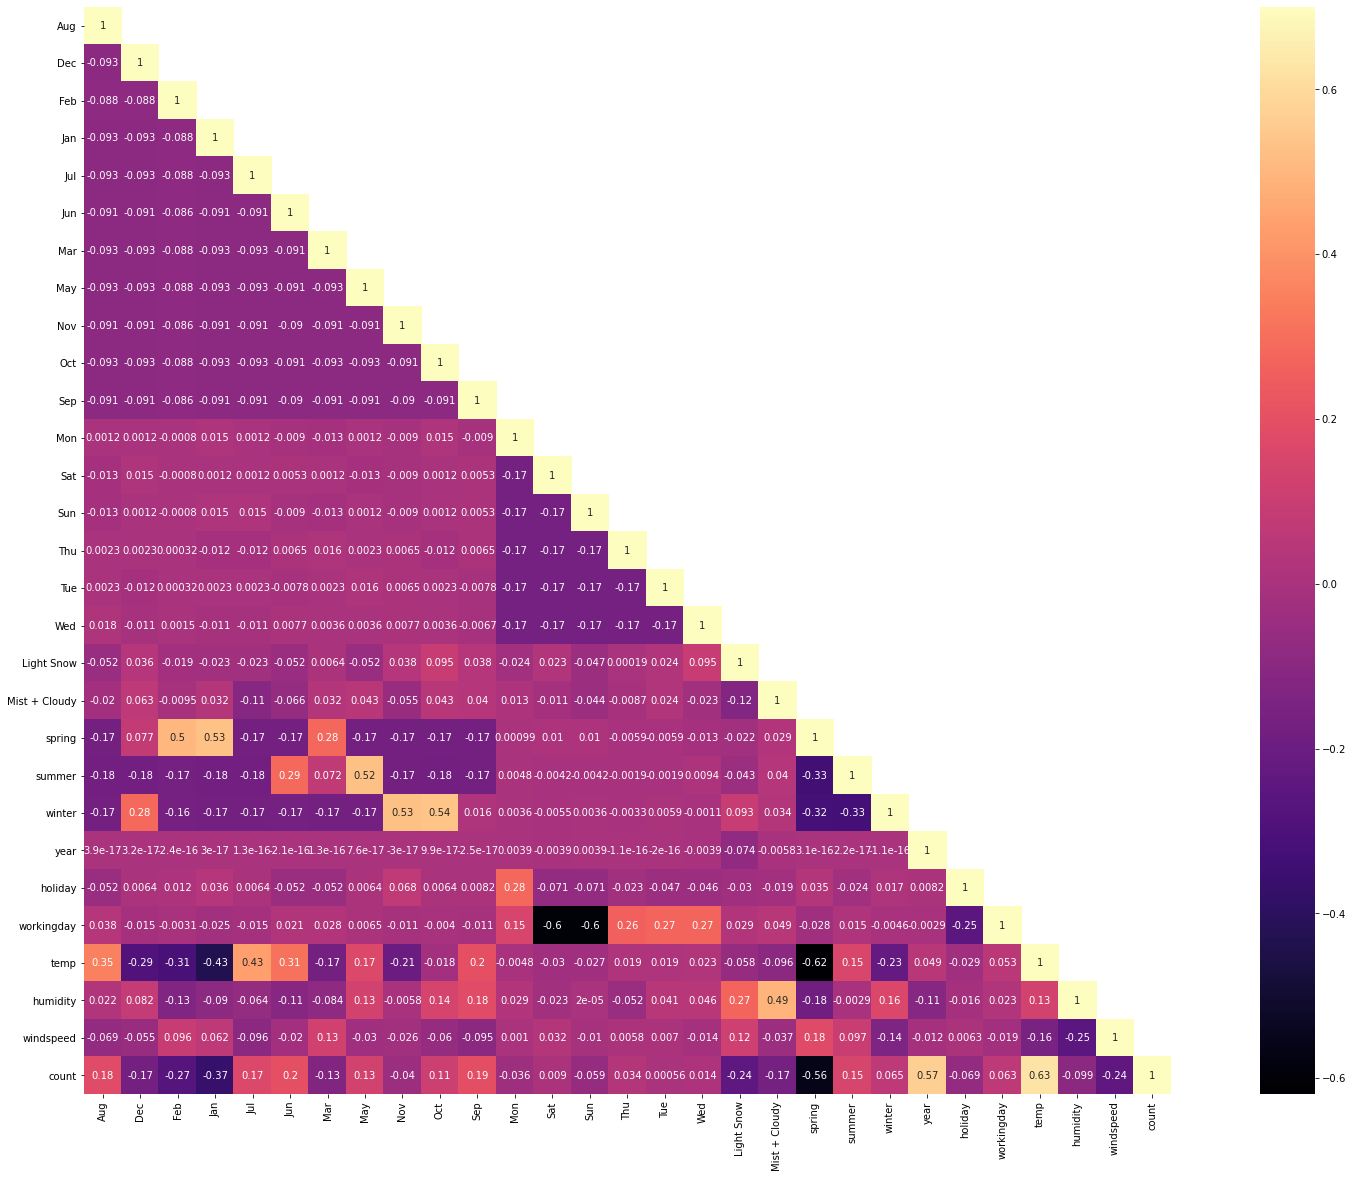

In [187]:
#Recheck the Collinearity of variables
plt.figure(figsize=(32,20))

mask = np.array(df.corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(df.corr(), mask=mask, vmax=.7, square=True, annot=True, cmap = "magma");

In [188]:
# Drop original variables since dummy variables are created
df.drop(['season','month','weekday','weathersit'], axis = 1, inplace = True)

df.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,...,spring,summer,winter,year,holiday,workingday,temp,humidity,windspeed,count
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,14.110847,80.5833,10.749882,985
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,14.902598,69.6087,16.652113,801
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,8.050924,43.7273,16.636703,1349
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,8.200000,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,9.305237,43.6957,12.522300,1600


In [189]:
#Checking total number of columns present finally
df.shape

(730, 29)

### Spliting Data into Train set and Test Set

In [190]:
# Split into train & test set
X_train, X_test = train_test_split(df, train_size = 0.7, random_state = 100)

# To check how many total collumns are present in train and test set
print ("Total collumns of Train Data: ", X_train.shape)
print ("Total collumns of Test Data: ", X_test.shape)

Total collumns of Train Data:  (510, 29)
Total collumns of Test Data:  (220, 29)


In [191]:
# To check on metrics for train dataset
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Aug,510.0,0.096078,0.294988,0.000000,0.000000,0.000000,0.000000,1.000000
Dec,510.0,0.084314,0.278131,0.000000,0.000000,0.000000,0.000000,1.000000
Feb,510.0,0.066667,0.249689,0.000000,0.000000,0.000000,0.000000,1.000000
Jan,510.0,0.088235,0.283915,0.000000,0.000000,0.000000,0.000000,1.000000
Jul,510.0,0.076471,0.266010,0.000000,0.000000,0.000000,0.000000,1.000000
Jun,510.0,0.076471,0.266010,0.000000,0.000000,0.000000,0.000000,1.000000
Mar,510.0,0.098039,0.297660,0.000000,0.000000,0.000000,0.000000,1.000000
May,510.0,0.084314,0.278131,0.000000,0.000000,0.000000,0.000000,1.000000
Nov,510.0,0.086275,0.281045,0.000000,0.000000,0.000000,0.000000,1.000000
Oct,510.0,0.084314,0.278131,0.000000,0.000000,0.000000,0.000000,1.000000


Most of variables are represented in terms of 0's and 1's except some numeric variable collumns like temperature, apparant temperature, humidity, windspeed, count needs to be addressed using rescaling technique.



### Rescaling the Features
It is technique of bringing all the varibles into comparable scale. From the above observations we understood all variables are represented in terms of 0's and 1's except some of the numerical collumns. So they have to be rescaled that would help further in model evaluation.

In this context Min-Max Scaling technique is used for rescaling.

However by scaling it does not affect the model performance results.

In [192]:
# Instantiate an object
scaler = MinMaxScaler()
 
# Create the list of Numeric Variables to be scaled
num_vars = ['temp','humidity','windspeed','count']
 
#fit on data
X_train[num_vars]=scaler.fit_transform(X_train[num_vars])
X_train[num_vars].head()

,temp,humidity,windspeed,count
576,0.815169,0.725633,0.264686,0.827658
426,0.442393,0.640189,0.255342,0.465255
728,0.245101,0.498067,0.663106,0.204096
482,0.395666,0.504508,0.188475,0.482973
111,0.345824,0.751824,0.380981,0.191095


### Dividing the training dataset into X and Y sets

In [193]:
# Dividing the train data into X & y sets for model building

# X Train dataset
X_train = X_train

# Y Train dataset
y_train = X_train.pop('count')

### Recursive Feature Elimination Method
To select feature one by one for training is a tedious process and to select all variables and then drop the variables one by one also seems to be confusing one. Therefore here LinearRegression function is utilised from SciKit Learn for its compatibility with RFE.

In [194]:
# In this experiment initial number of output variables were selected to be 20 upon which some varibles had very high vif 
# Therefore number of output varibles was reset to 12

# Execute RFE with output number of variables = 12
lm = LinearRegression()

lm.fit(X_train, y_train)

rfe = RFE(lm, 12)
rfe = rfe.fit(X_train, y_train)

In [195]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Aug', False, 12),
 ('Dec', False, 7),
 ('Feb', False, 8),
 ('Jan', False, 5),
 ('Jul', False, 4),
 ('Jun', False, 14),
 ('Mar', False, 17),
 ('May', False, 11),
 ('Nov', False, 6),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Mon', False, 9),
 ('Sat', True, 1),
 ('Sun', False, 3),
 ('Thu', False, 15),
 ('Tue', False, 10),
 ('Wed', False, 16),
 ('Light Snow', True, 1),
 ('Mist + Cloudy', True, 1),
 ('spring', False, 2),
 ('summer', True, 1),
 ('winter', True, 1),
 ('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1)]

In [196]:
# To view the column choosed by RFE
rfe_col = X_train.columns[rfe.support_]
rfe_col

Index(['Sep', 'Sat', 'Light Snow', 'Mist + Cloudy', 'summer', 'winter', 'year',
       'holiday', 'workingday', 'temp', 'humidity', 'windspeed'],
      dtype='object')

In [197]:
# To view the column not choosen by RFE
X_train.columns[~rfe.support_]

Index(['Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Mon', 'Sun', 'Thu', 'Tue', 'Wed', 'spring'],
      dtype='object')

### Building the model using statsmodel, for understanding p value, Rsquared, P(Fstatistic) metric

#### First Iteration Model Building

In [198]:
# Creating rfe dataframe with RFE selected variables
X_train_rfe = X_train[rfe_col]

In [199]:
X_train_bklm = sm.add_constant(X_train_rfe)

In [200]:
bklm = sm.OLS(y_train,X_train_bklm).fit()

In [201]:
#Let's see the summary of our linear model
print(bklm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     221.9
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          8.26e-191
Time:                        18:02:54   Log-Likelihood:                 510.60
No. Observations:                 510   AIC:                            -995.2
Df Residuals:                     497   BIC:                            -940.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1810      0.029      6.258

In [202]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,humidity,16.48
9,temp,8.12
8,workingday,5.02
11,windspeed,3.79
3,Mist + Cloudy,2.11
6,year,2.02
1,Sat,1.90
5,winter,1.66
4,summer,1.58
0,Sep,1.21


When we observe the data its observed that variable humidity has high vif therefore this variable need to be dropped.

In [203]:
X_train_rfe = X_train_rfe.drop(['humidity'], axis = 1)

### Second Iteration Model Building

In [204]:
# Adding a constant variable 
X_train_bklm = sm.add_constant(X_train_rfe)
bklm = sm.OLS(y_train,X_train_bklm).fit()   # Running the linear model
bklm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     231.9
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          6.43e-188
Time:                        18:28:19   Log-Likelihood:                 500.92
No. Observations:                 510   AIC:                            -977.8
Df Residuals:                     498   BIC:                            -927.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0845      0.019      4.420      0.000       0.047       0.122
Sep               0.0994      0.016      6.319      0.000       0.068       0.130
Sat               0.0590      0.015      3.951      0.000       0.030       0.088
Light Snow       -0.2884      0.025    -11.695      0.000      -0.337      -0.240
Mist + Cloudy    -0.0805      0.009     -9.225      0.000      -0.098      -0.063
summer            0.0880      0.010      8.572      0.000       0.068       0.108
winter            0.1310      0.010     12.668      0.000       0.111       0.151
year              0.2330      0.008     28.443      0.000       0.217       0.249
holiday          -0.0567      0.028     -2.044      0.041      -0.111      -0.002
workingday        0.0477      0.012      4.020      0.000       0.024       0.071
temp              0.5477      0.020     27.797      0.000       0.509       0.586
windspeed        -0.1542      0.025     -6.175      0.000      -0.203      -0.105
==============================================================================
Omnibus:                       64.101   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.736
Skew:                          -0.698   Prob(JB):                     2.03e-30
Kurtosis:                       5.118   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [205]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,temp,4.84
8,workingday,4.35
10,windspeed,3.55
6,year,2.02
1,Sat,1.76
4,summer,1.57
3,Mist + Cloudy,1.53
5,winter,1.41
0,Sep,1.21
7,holiday,1.12


### Residual Analysis of Training data

To reconfirm if the error terms are also normally distributed (which is the major assumptions of linear regression), can plot the histogram of the error terms and further check on the observations

In [206]:
y_train_cnt = bklm.predict(X_train_bklm)

Text(0.5, 0, 'Errors')

<Figure size 432x288 with 0 Axes>

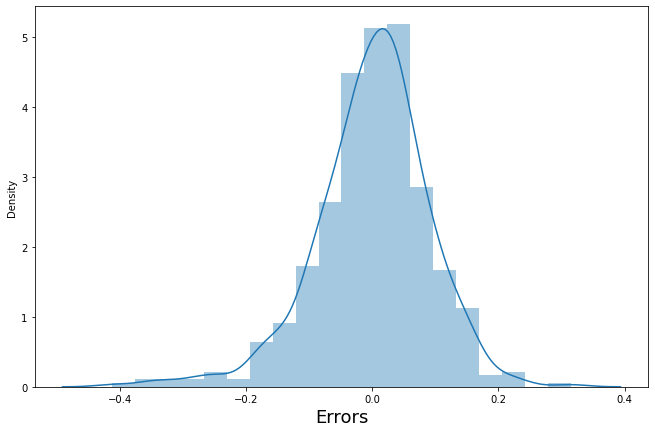

In [207]:
# Plot the histogram of the error terms
fig = plt.figure()
plt.figure(figsize=(11,7))
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

From the above observations it is observed that errors have normal distribution.

### Model Predictions and Final Model Evaluation

In [211]:
num_test = ['temperature','humidity','windspeed','count']

X_test[num_vars] = scaler.transform(X_test[num_vars])

### Diving Test set into X_test and y_test

In [212]:
y_test = X_test.pop('count')
X_test = X_test

In [213]:
# predicting using values used by the final model
test_col = X_train_bklm.columns
X_test=X_test[test_col[1:]]

# Adding constant variable to test dataframe
X_test = sm.add_constant(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 184 to 653
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          220 non-null    float64
 1   Sep            220 non-null    uint8  
 2   Sat            220 non-null    uint8  
 3   Light Snow     220 non-null    uint8  
 4   Mist + Cloudy  220 non-null    uint8  
 5   summer         220 non-null    uint8  
 6   winter         220 non-null    uint8  
 7   year           220 non-null    int64  
 8   holiday        220 non-null    int64  
 9   workingday     220 non-null    int64  
 10  temp           220 non-null    float64
 11  windspeed      220 non-null    float64
dtypes: float64(3), int64(3), uint8(6)
memory usage: 13.3 KB


In [214]:
# Making predictions using the Second model
y_bkpred = bklm.predict(X_test)

In [215]:
#Calculating RSquare value
r2_score(y_test, y_bkpred)

0.7969008872616741

Text(0, 0.5, 'y_pred')

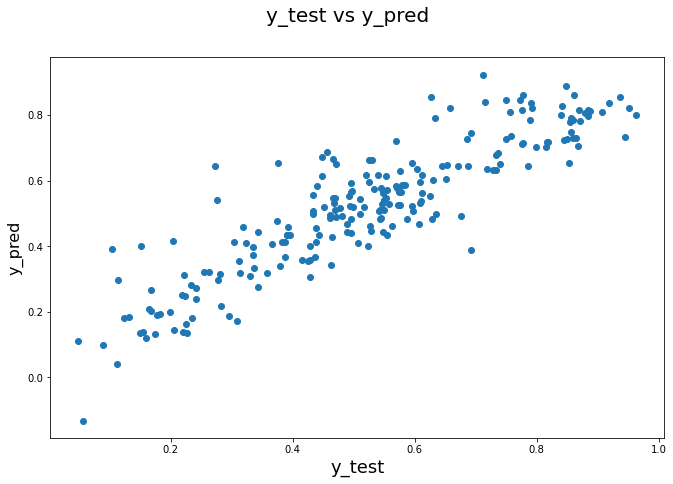

In [216]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure(figsize=(11,7))
plt.scatter(y_test, y_bkpred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 

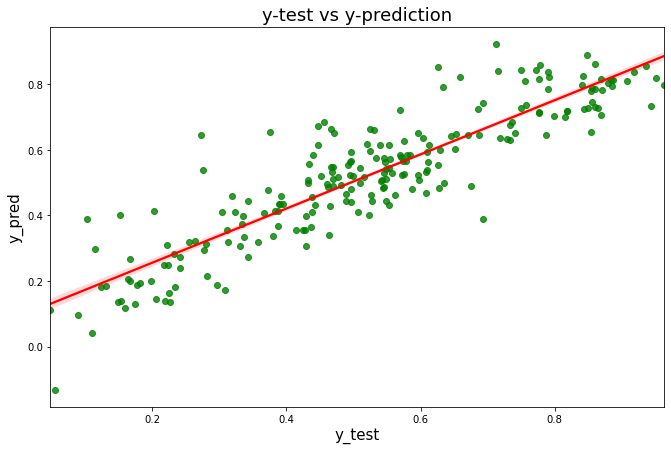

In [217]:
#Regression plot
plt.figure(figsize=(11,7))
sns.regplot(x=y_test, y=y_bkpred, ci=68, fit_reg=True,scatter_kws={"color": "green"}, line_kws={"color": "red"})

plt.title('y-test vs y-prediction', fontsize=18)              
plt.xlabel('y_test', fontsize=15)                          
plt.ylabel('y_pred', fontsize=15)                          
plt.show()

### Observations:

R2 values is aorund 83% - which is good.

VIF values are less than 5.

p values of cofficients are minimal.

There is the linear relation between y_test and y-pred which is also very good.

In Residual Analysis is normally distributed having mean at 0.

In [218]:
param = pd.DataFrame(bklm.params)
param.insert(0,'Variables',param.index)
param.rename(columns = {0:'Coefficient value'},inplace = True)
param['index'] = list(range(0,12))
param.set_index('index',inplace = True)
param.sort_values(by = 'Coefficient value',ascending = False,inplace = True)
param

,Variables,Coefficient value
index,,
10,temp,0.547700
7,year,0.233003
6,winter,0.130958
1,Sep,0.099363
5,summer,0.088003
0,const,0.084514
2,Sat,0.058986
9,workingday,0.047717
8,holiday,-0.056709


The equation of our best fitted line is:

count = 0.084514 + 0.547700 X temperature + 0.233003 X year + 0.130958 X winter + 0.099363 X Sep + 0.088003 X summer  -0.288352 X Light Snow -0.080511 X Mist & Cloudy -0.056709 X holiday -0.154226 X windspeed

### Conclusion
Temparature is the varible with highest coefficiant value there by which influences count of bike rentals directly.

Year - bike rental count is increasing every year.

September is the month where count of bike rentals is more.

Light Snow and windspeed has negative coefficiant value indicating that as there value increase count of bike rentals become less.